# Tychon Assignment By Akhil

This notebook involves useful experiments done to arrive at the solution.
The final code should be in `painting_swapper.py`

In [ ]:
from os import listdir
from os.path import join
import cv2
import numpy as np
import requests
from PIL import Image
import matplotlib.pyplot as plt
from random import randint

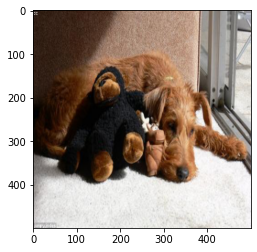

In [2]:
def get_random_image(h, w, keyword):
    # return np.ones((h, w, 3)) * randint(0, 255)
    try:
        url = f'https://loremflickr.com/480/320/{keyword}'
        img = Image.open(requests.get(url, stream=True).raw)
        img = img.convert('RGB')
        img = np.array(img, dtype=np.uint8)
        img = cv2.resize(img, (w, h))
        return img
    except Exception as e:
        print(e)
        return np.ones((h, w, 3)) * randint(0, 255)


plt.imshow(get_random_image(500, 500, 'puppy'))

In [3]:
images_path = './data'
image_names = sorted(listdir(images_path))
image_names

['001.jpg',
 '002.jpg',
 '003.jpg',
 '004.jpg',
 '005.jpg',
 '006.jpg',
 '007.jpg',
 '008.jpg',
 '009.jpg',
 '010.jpg']

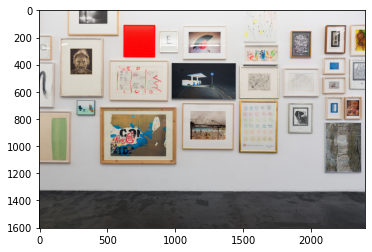

In [4]:
i = 3

image_name = image_names[i]
image_path = join(images_path, image_name)
image = Image.open(image_path)
image = np.array(image, np.uint8)
plt.imshow(image)

# Finding the paintings

1. Canny edge detection
2. [Adaptive Gaussian Thresholding](https://docs.opencv.org/master/d7/d4d/tutorial_py_thresholding.html)
3. Find contours
4. Filter the contours

In [5]:
def show_contours(contours, shape):
    blank = np.zeros(shape)
    cv2.drawContours(blank, contours, -1, (255, 255, 255), 3)
    plt.imshow(blank)
    plt.show()

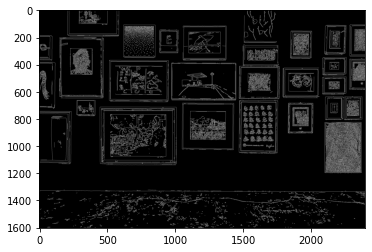

In [6]:
# best = 50, 100 empirically
edges = cv2.Canny(image, 50, 100)
plt.imshow(edges, cmap='gray')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


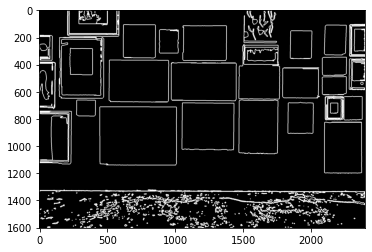

In [7]:
# best = 11, 35 empirically
thresholded = cv2.adaptiveThreshold(edges, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 35)
contours, _ = cv2.findContours(thresholded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
show_contours(contours, image.shape)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


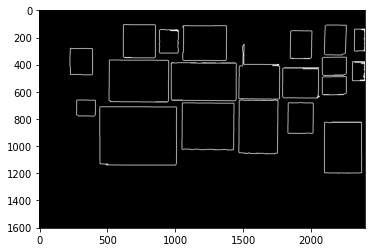

In [8]:
best_contours = []
for contour in contours:
    _, _, w, h = cv2.boundingRect(contour)
    aspect_ratio = w / h
    if aspect_ratio < 0.3 or aspect_ratio > 7:
        continue

    area = cv2.contourArea(contour)
    if area < 8000:
        continue

    rect_area = w * h
    rectangle_ratio = area / rect_area
    if rectangle_ratio < 0.6:
        continue

    best_contours.append(contour)

show_contours(best_contours, image.shape)

Although it didn't find all the paintings, this is good enough.

# Replacing the paintings.

Assumption: Resized puppy images = puppy image with modified perspective.

1. In a blank image, place all the puppies to fill the painting bounding boxes.
2. Create a mask image by filling the contours.
3. Apply mask intersection with puppies
4. Apply intersection b/w image and inverse mask so that we get all the background.
5. Now add background and puppies

In [ ]:
out = np.zeros_like(image)

for contour in best_contours:
    x1, y1, w, h = cv2.boundingRect(contour)
    out[y1: y1 + h, x1: x1 + w] = get_random_image(h, w, 'puppy')

plt.imshow(out)

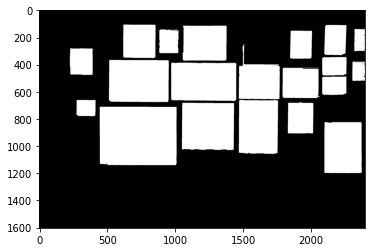

In [10]:
mask = np.zeros_like(image, np.uint8)
cv2.drawContours(mask, best_contours, -1, (255, 255, 255), -1)
plt.imshow(mask, cmap='gray')

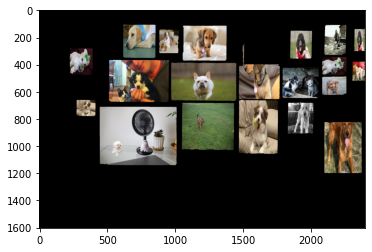

In [11]:
out = out & mask
plt.imshow(out)

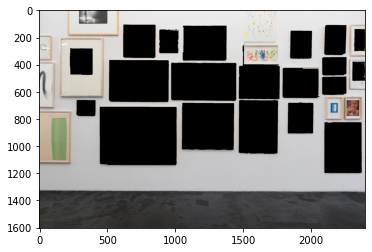

In [12]:
image = image & ~mask
plt.imshow(image)

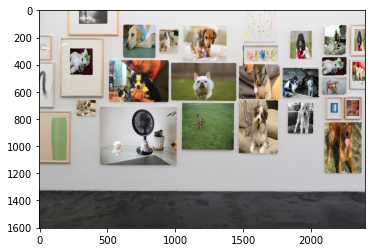

In [13]:
final_image = out + image
plt.imshow(final_image)